In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [2]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

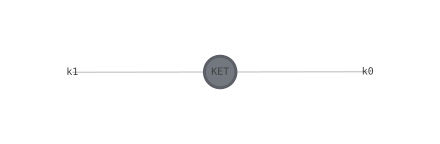

In [3]:
ket.draw()

In [4]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])

And finally, a random 'bra' to complete the inner product:

In [5]:
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])

In [6]:
TN = ket.H & X & Y & bra
print(TN)

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET'])),
    Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0'])),
    Tensor(shape=(2, 2), inds=('k1', 'b1'), tags=oset(['PAULI', 'Y', '1'])),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['BRA'])),
])


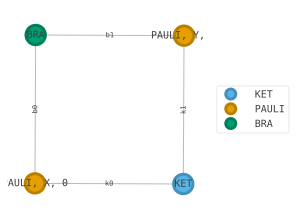

In [7]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

Note the tags can be used to identify both paulis at once. But they could also be uniquely identified using their ``'X'`` and ``'Y'`` tags respectively:

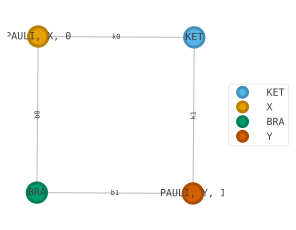

In [8]:
TN.draw(color=['KET', 'X', 'BRA', 'Y'], figsize=(4, 4), show_inds='all', iterations=1000)

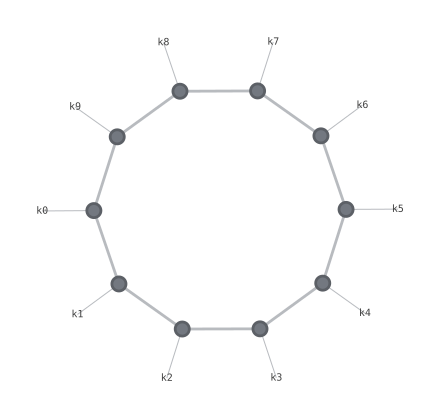

In [9]:
L = 10

# create the nodes, by default just the scalar 1.0
tensors = [qtn.Tensor() for _ in range(L)]

for i in range(L):
    # add the physical indices, each of size 2
    tensors[i].new_ind(f'k{i}', size=2)
    
    # add bonds between neighbouring tensors, of size 7
    tensors[i].new_bond(tensors[(i + 1) % L], size=7)
    
mps = qtn.TensorNetwork(tensors)
mps.draw()

In [10]:
TN ^ ...

(-0.09359096834041335-0.14038220878152025j)

Or if you only want to contract tensors with a specific set of tags, such as the two pauli operators,
supply a tag or sequence of tags:

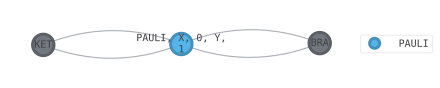

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET'])),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['BRA'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k0', 'b0', 'k1', 'b1'), tags=oset(['PAULI', 'X', '0', 'Y', '1'])),
])


In [11]:
TNc = TN ^ 'PAULI'
TNc.draw('PAULI')
print(TNc)

In [12]:
ta = qtn.rand_tensor([2, 3], inds=['a', 'x'], tags='A')
tb = qtn.rand_tensor([4, 3], inds=['b', 'x'], tags='B')

# matrix multiplication but with indices aligned automatically
ta @ tb

Tensor(shape=(2, 4), inds=('a', 'b'), tags=oset(['A', 'B']))

In [13]:
# get a normalized tensor network
psi = qtn.MPS_rand_state(10, 7)

# compute its norm squared
psi.H @ psi  # == (tn.H & tn) ^ ...

1.000000000000001

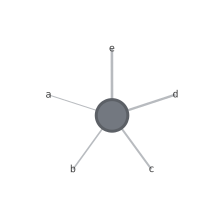

In [14]:
# create a tensor with 5 legs
t = qtn.rand_tensor([2, 3, 4, 5, 6], inds=['a', 'b', 'c', 'd', 'e'])
t.draw(initial_layout='kamada_kawai', figsize=(3, 3))

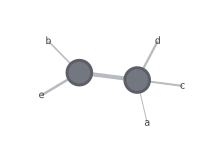

In [15]:
# split the tensor, by grouping some indices as 'left'
tn = t.split(['a', 'c', 'd'])
tn.draw(figsize=(3, 3))

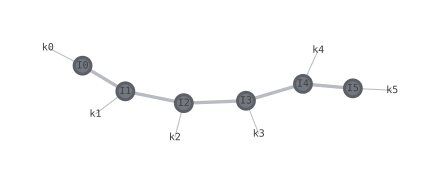

In [16]:
psi = qtn.MPS_rand_state(6, 10)
psi.draw()

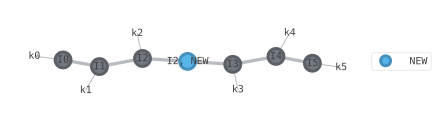

In [17]:
psi.split_tensor(
    # identify the tensor
    tags='I2', 
    # here we give the right indices
    left_inds=None,
    right_inds=[psi.bond(2, 3)],
    # a new tag for the right factor
    rtags='NEW',
)

psi.draw('NEW')

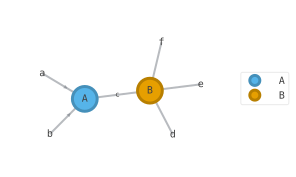

In [18]:
ta = qtn.rand_tensor([4, 4, 4], ['a', 'b', 'c'], 'A')
tb = qtn.rand_tensor([4, 4, 4, 4], ['c', 'd', 'e', 'f'], 'B')

qtn.tensor_canonize_bond(ta, tb)

(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='all')

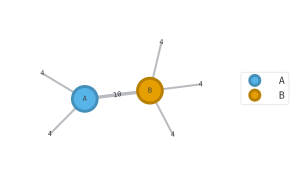

In [19]:
ta = qtn.rand_tensor([4, 4, 10], ['a', 'b', 'c'], 'A')
tb = qtn.rand_tensor([10, 4, 4, 4], ['c', 'd', 'e', 'f'], 'B')
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

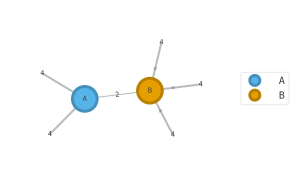

In [20]:
# perform the compression
qtn.tensor_compress_bond(ta, tb, max_bond=2, absorb='left')

# should now see the bond has been reduced in size to 2
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

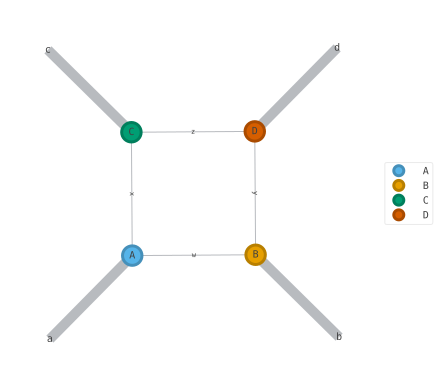

In [21]:
ta = qtn.rand_tensor([1000, 2, 2], inds=['a', 'w', 'x'], tags='A')
tb = qtn.rand_tensor([1000, 2, 2], inds=['b', 'w', 'y'], tags='B')
tc = qtn.rand_tensor([1000, 2, 2], inds=['c', 'x', 'z'], tags='C')
td = qtn.rand_tensor([1000, 2, 2], inds=['d', 'y', 'z'], tags='D')
tn = (ta | tb | tc | td)
tn.draw(['A', 'B', 'C', 'D'], show_inds='all')

In [22]:
tnlo = tn.aslinearoperator(['a', 'b'], ['c', 'd'])
tnlo

<1000000x1000000 TNLinearOperator with dtype=float64>

In [23]:
qu.eigvals(tnlo, k=1, which='LM')

array([-5832.07736565+0.j])

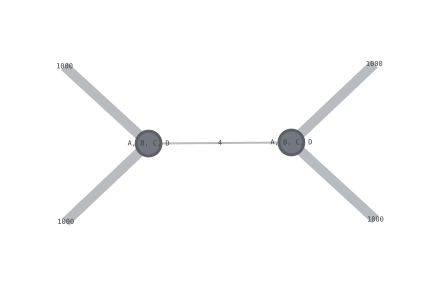

In [24]:
tn_decomp = qtn.tensor_split(
    tnlo,
    left_inds=tnlo.left_inds,
    right_inds=tnlo.right_inds,
    # make sure we supply a iterative method
    method='svds',  # {'rsvd', 'isvd', 'eigs', ...}
    max_bond=4,
)

tn_decomp.draw(show_inds='bond-size')

In [25]:
tn = qtn.TN2D_rand(5, 5, D=4)

Get tensors which have **all** of the tags:

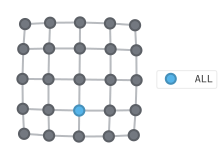

In [26]:
tn.select(tags=['ROW2', 'COL3'], which='all').add_tag('ALL')    
tn.draw('ALL', figsize=(3, 3))

Get tensors which *don't* have **all** of the tags:

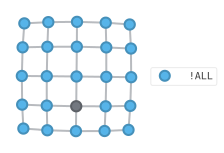

In [27]:
tn.select(tags=['ROW2', 'COL3'], which='!all').add_tag('!ALL')
tn.draw('!ALL', figsize=(3, 3))

Get tensors which have **any** of the tags:

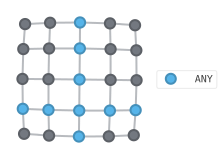

In [28]:
tn.select(tags=['ROW2', 'COL3'], which='any').add_tag('ANY')
tn.draw('ANY', figsize=(3, 3))

Get tensors which *don't* have **any** of the tags:

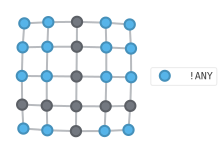

In [29]:
tn.select(tags=['ROW2', 'COL3'], which='!any').add_tag('!ANY')  
tn.draw('!ANY', figsize=(3, 3))

In [30]:
tn['ROW2', 'COL3']

Tensor(shape=(4, 4, 4, 4), inds=('_c2e8acAAABX', '_c2e8acAAABZ', '_c2e8acAAABa', '_c2e8acAAABR'), tags=oset(['I2,3', 'ROW2', 'COL3', 'ALL', 'ANY']))

Although some special tensor networks also accept a lattice coordinate here as well:

In [31]:
tn[2, 3]

Tensor(shape=(4, 4, 4, 4), inds=('_c2e8acAAABX', '_c2e8acAAABZ', '_c2e8acAAABa', '_c2e8acAAABR'), tags=oset(['I2,3', 'ROW2', 'COL3', 'ALL', 'ANY']))

In [32]:
tn = qtn.TensorNetwork([ta, tb, tc, td], virtual=True)

which is equivalent to

In [33]:
tn = (ta | tb | tc | td)

the new TN is *viewing* those tensors and so changes to them will affect ``tn`` 
and vice versa. Note this is *not* the default behaviour.

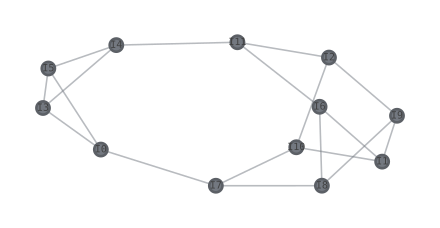

In [34]:
tn = qtn.TN_rand_reg(12, 3, 3, seed=42)
tn.draw()

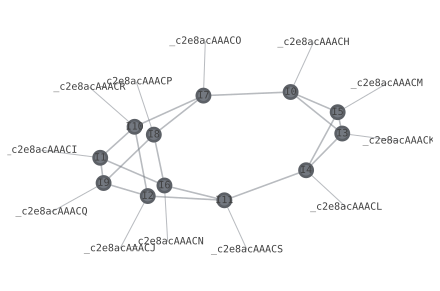

In [35]:
# add a random dangling index to each tensor
for t in tn:
    t.new_ind(qtn.rand_uuid(), size=2)

tn.draw()

In [36]:
# the TN efficiently keeps track of all indices and tags still
tn.outer_inds()

('_c2e8acAAACH',
 '_c2e8acAAACI',
 '_c2e8acAAACJ',
 '_c2e8acAAACK',
 '_c2e8acAAACL',
 '_c2e8acAAACM',
 '_c2e8acAAACN',
 '_c2e8acAAACO',
 '_c2e8acAAACP',
 '_c2e8acAAACQ',
 '_c2e8acAAACR',
 '_c2e8acAAACS')